#*Stock price prediction using LSTM*

> Indented block




* [__Introduction to Data__](#1)
* [Import Libraries and Data Input](#2)
* [Data Cleaning](#3)
* [Visualizing the datasets](#4)
    * [Nifty 50 Close Price Visulization](#5)
    * [Nifty BANK Close Price Visulization](#6)
* [Comparing time series](#7)
* [The augmented Dicky-Fuller test](#8)
* [Making a time series stationary](#9)
    * [Difference Δyt = yt − yt−1](#10)
    * [proportional change](#11)
* [Window functions](#12)
* [Financial Charts](#13)
    * [OHLC chart](#14)
    * [Candlestick chart](#15)
* [Time series decomposition](#16)
* [Autocorrelation and Partial Autocorrelation](#17)
* [Using ACF and PACF to choose model order](#18)
* [SARIMAXA Model](#19)
* [SARIMAXA Model diagnostics](#20)
* [Prediction on train data](#21)
* [Forecasting on train data](#22)
* [Plot Prediction and Forcasting](#23)

## <font color='blue'>LSTM</font>
* [Import Liberary](#24)
* [Data Preprocessing](#25)
* [LSTM Model](#26)
* [Model training](#27)
* [Model Prediction](#28)
* [RMS Error of model](#29)
* [Plot Prediction](#30)

## Introduction to Data<a id='1'></a>
* The National Stock Exchange of India Limited (NSE) is the leading stock exchange of India, located in Mumbai. The NIFTY 50 index is National Stock Exchange of India's benchmark broad based stock market index for the Indian equity market. 

* This dataset has day level information on major NIFTY indices starting from 01 January 2000.

* Each file represents an index and has the following columns

> * **Date** - date of observation
* **Open** - open value of the index on that day
* **High** - highest value of the index on that day
* **Low** - lowest value of the index on that day
* **Close** - closing value of the index on that day
* **Volume** - volume of transaction
* **Turnover** - turn over
* **P/E** - price to earnings ratio
* **P/B** - price to book value
* **Div Yield** - dividend yield


## Import Libraries and Data Input<a id='2'></a>

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
color = sns.color_palette()
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import plotly.offline as py
from plotly import tools
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
nifty_50_df = pd.read_csv("/content/NIFTY 50.csv", index_col='Date', parse_dates=['Date'])
nifty_bank_df = pd.read_csv("/content/NIFTY BANK.csv", index_col='Date', parse_dates=['Date'])

print(nifty_50_df.shape)
nifty_50_df.head(5)

(5061, 9)


,Open,High,Low,Close,Volume,Turnover,P/E,P/B,Div Yield
Date,,,,,,,,,
2000-01-03,1482.15,1592.90,1482.15,1592.2,25358322.0,8.841500e+09,25.91,4.63,0.95
2000-01-04,1594.40,1641.95,1594.40,1638.7,38787872.0,1.973690e+10,26.67,4.76,0.92
2000-01-05,1634.55,1635.50,1555.05,1595.8,62153431.0,3.084790e+10,25.97,4.64,0.95
2000-01-06,1595.80,1639.00,1595.80,1617.6,51272875.0,2.531180e+10,26.32,4.70,0.94
2000-01-07,1616.60,1628.25,1597.20,1613.3,54315945.0,1.914630e+10,26.25,4.69,0.94


In [ ]:
nifty_50_df.tail(5)

,Open,High,Low,Close,Volume,Turnover,P/E,P/B,Div Yield
Date,,,,,,,,,
2020-05-04,9533.50,9533.50,9266.95,9293.50,NaN,NaN,21.39,2.65,1.64
2020-05-05,9429.40,9450.90,9190.75,9205.60,725196178.0,2.970020e+11,21.19,2.62,1.65
2020-05-06,9226.80,9346.90,9116.50,9270.90,722185448.0,3.079810e+11,21.34,2.64,1.64
2020-05-07,9234.05,9277.85,9175.90,9199.05,708740416.0,5.970553e+11,21.18,2.62,1.65
2020-05-08,9376.95,9382.65,9238.20,9251.50,609053504.0,3.074345e+11,21.28,2.64,1.64


* <font color='red'>P/E</font>: The basic definition of a P/E ratio is stock price divided by <font color='Blue'>earnings per share</font> (EPS).
* <font color='red'>P/B</font>: The P/B ratio compares a company's market capitalization, or market value, to its <font color='Blue'>book value</font>.
* <font color='red'>Open</font> : the last trading price of the previous day
* <font color='red'>Close</font> : trading price of the day.
* <font color='red'>Dividend yield</font> is the financial ratio that measures the quantum of cash dividends paid out to shareholders relative to the market value per share. It is computed by dividing the dividend per share by the market price per share and multiplying the result by 100.

## Data Cleaning<a id='3'></a>

* <font color='red'>nifty_50_df</font> have data does have missing values. It is cleaned using <font color='red'>fillna()</font> method with ffill parameter which propagates last valid observation to fill gaps

In [ ]:
nifty_50_df = nifty_50_df.fillna(method='ffill')
nifty_bank_df = nifty_bank_df.fillna(method='ffill')

## Visualizing the datasets<a id='4'></a>

In [ ]:
def plot_attribute(df, attritube ,start='2000', end='2020',color ='blue'):
    fig, ax = plt.subplots(1, figsize=(20,5))
    ax.plot(df[start:end].index, df[start:end][attritube],'tab:{}'.format(color))
    ax.set_title("Nifty stock {} from 2000 to 2020".format(attritube))
    
    ax.axhline(y=df[start:end].describe()[attritube]["max"],linewidth=2, color='m')
    ax.axhline(y=df[start:end].describe()[attritube]["min"],linewidth=2, color='c')
    ax.axvline(x=df[attritube].idxmax(),linewidth=2, color='b')
    ax.axvline(x=df[attritube].idxmin() ,linewidth=2, color='y')
    
    ax.text(x=df[attritube].idxmax(),
            y=df[start:end].describe()[attritube]["max"],
            s='MAX',
            horizontalalignment='right',
            verticalalignment='bottom',
            color='blue',
            fontsize=20)
    
    ax.text(x=df[attritube].idxmin(),
            y=df[start:end].describe()[attritube]["min"],
            s='MIN',
            horizontalalignment='left',
            verticalalignment='top',
            color='red',
            fontsize=20)
    
    plt.show()
    print("Max Value :  ",df[start:end].describe()[attritube]["max"])
    print("Min Value :  ",df[start:end].describe()[attritube]["min"])


### Nifty 50 Close Price Visulization<a id='5'></a>

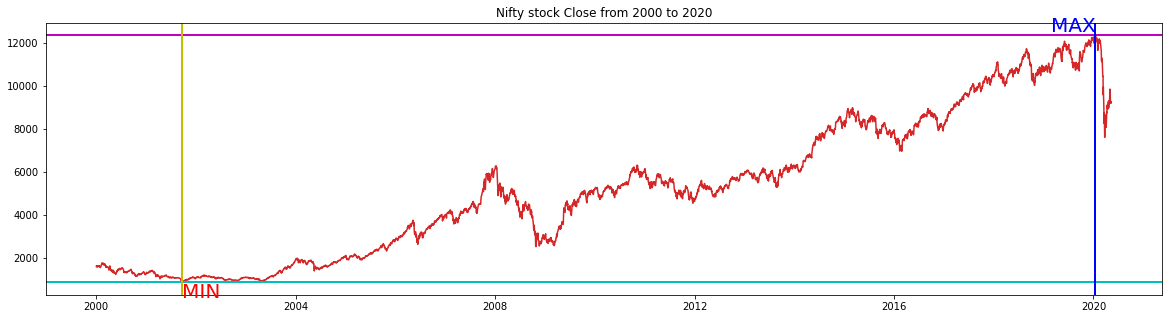

Max Value :   12362.3
Min Value :   854.2


In [ ]:
plot_attribute(nifty_50_df,"Close",color='red')

### Nifty BANK Close Price Visulization<a id='6'></a>

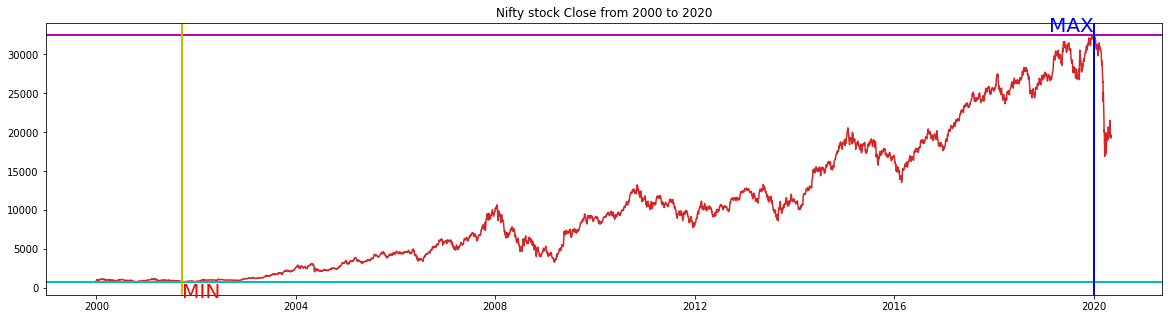

Max Value :   32443.85
Min Value :   743.7


In [ ]:
plot_attribute(nifty_bank_df,"Close",color='red')

## Comparing time series<a id='7'></a>
We will compare time series by normalizing them. This is achieved by dividing each time series element of all time series by the first element. This way both series start at the same point and can be easily compared.

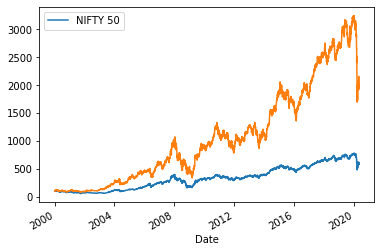

In [ ]:
normalised_nifty_50_df = nifty_50_df["Close"].div(nifty_50_df["Close"].iloc[0]).mul(100)
normalised_nifty_bank_df = nifty_bank_df["Close"].div(nifty_bank_df['Close'].iloc[0]).mul(100)
normalised_nifty_50_df.plot()
normalised_nifty_bank_df.plot()
plt.legend(['NIFTY 50'])
plt.show()

## The augmented Dicky-Fuller test<a id='8'></a>
* Tests for trend non-stationarity 
* Null hypothesis is time series is non-stationary

In [ ]:
dicky_fuller_result = adfuller(nifty_50_df['Close'])
dicky_fuller_result

(-0.7655677955763285,
 0.82902767044921,
 25,
 5035,
 {'1%': -3.4316494313795944,
  '10%': -2.5670756520148434,
  '5%': -2.8621142090353557},
 57330.470236984984)

* 0th element is test statistic (-0.7655677955763277) 
> More negative means more likely to be stationary 

* 1st element is p-value: (0.8290276704492101) 
> 1. If p-value is small then 0.05→reject null hypothesis. Reject non-stationary.
> 2. which is more than 0.05 null hypothesis is True and this is a random walk.¶

* 4th element is the criticaltest statistics


## **Making a time series stationary**<a id='9'></a>
* Taking the difference
> Difference: Δyt = yt − yt−1
* Take the log 
> np.log(df) 
* Take the square root 
> np.sqrt(df) 
* Take the proportional change 
> df.shift(1)/df

### Difference Δyt = yt − yt−1<a id='10'></a>

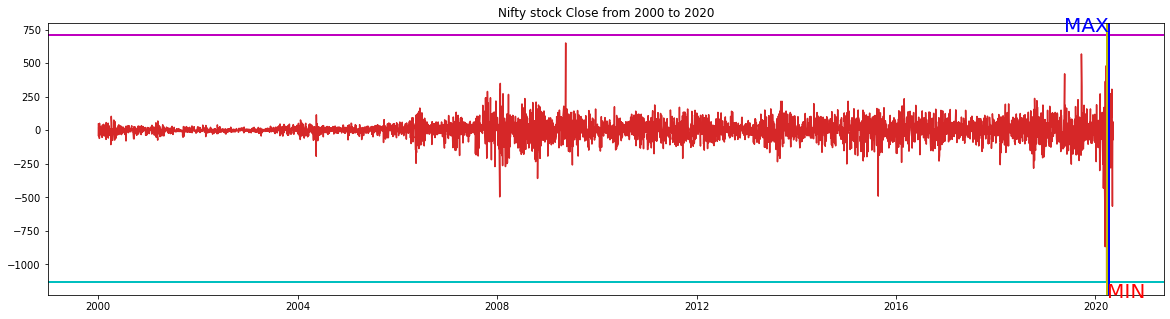

Max Value :   708.4000000000005
Min Value :   -1135.2000000000007


In [ ]:
plot_attribute(nifty_50_df.diff(),"Close",color='red')

* difference 1 is a stationary series, here we can't see trend
* Trend stationary: Trend is zero
* Variance is constant

### proportional change <a id='11'></a>

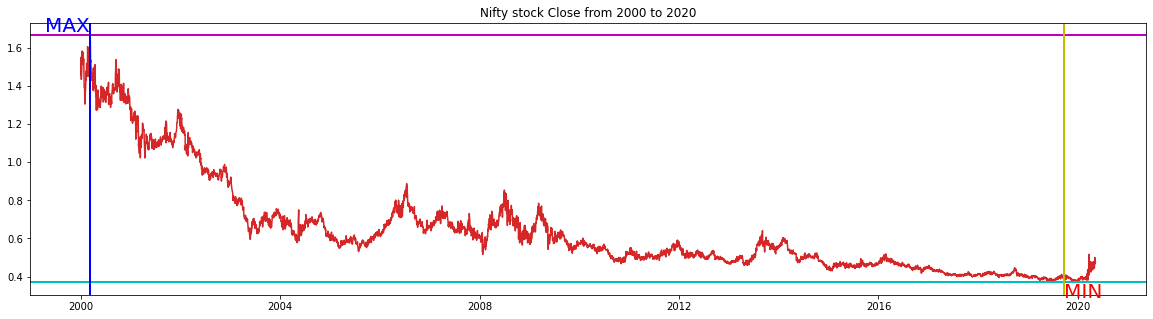

Max Value :   1.6664473417824028
Min Value :   0.3688453258828379


In [ ]:
plot_attribute(nifty_50_df.shift(1)/nifty_bank_df,"Close",color='red')

* Proportional change of nifty_50 data makes not series a stationary series ... we can see here negative trend

## Window functions<a id='12'></a>
* Window functions are used to identify sub periods, calculates sub-metrics of sub-periods.
1. **Rolling** - Same size and sliding
2. **Expanding** - Contains all prior values

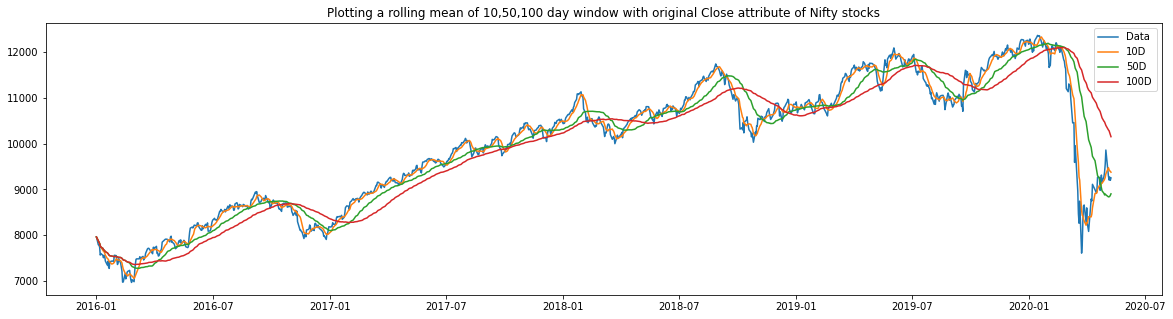

In [ ]:
some_part_of_data = nifty_50_df['2016':'2020']

rolling_nifty_50_df_10 = some_part_of_data['Close'].rolling('10D').mean()
rolling_nifty_50_df_50 = some_part_of_data['Close'].rolling('50D').mean()
rolling_nifty_50_df_100 = some_part_of_data['Close'].rolling('100D').mean()

fig, ax = plt.subplots(1, figsize=(20,5))
ax.plot(some_part_of_data.index,some_part_of_data['Close'])
ax.plot(rolling_nifty_50_df_10.index, rolling_nifty_50_df_10)
ax.plot(rolling_nifty_50_df_50.index, rolling_nifty_50_df_50)
ax.plot(rolling_nifty_50_df_100.index, rolling_nifty_50_df_100)
ax.set_title("Plotting a rolling mean of 10,50,100 day window with original Close attribute of Nifty stocks")
plt.legend(['Data','10D','50D','100D'])
plt.show()

# Financial Charts<a id='13'></a>

## OHLC chart<a id='14'></a>

The [OHLC](https://plotly.com/python/ohlc-charts/) chart (for open, high, low and close) is a style of financial chart describing open, high, low and close values for a given x coordinate (most likely time). The tip of the lines represent the low and high values and the horizontal segments represent the open and close values. Sample points where the close value is higher (lower) then the open value are called increasing (decreasing). By default, increasing items are drawn in green whereas decreasing are drawn in red.

In [ ]:
# Obtain data from the data frame
OHLC_data = nifty_50_df['3-2020':'2020']

fig = go.Figure(data=go.Ohlc(x=OHLC_data.index,
                            open=OHLC_data['Open'],
                            high=OHLC_data['High'],
                            low=OHLC_data['Low'],
                            close=OHLC_data['Close']))

fig.update_layout(title_text='Nifty 50 From March 2020 to May 2020',
                  title={
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'},
                  xaxis_rangeslider_visible=True, 
                  xaxis_title="Time", 
                  yaxis_title="Price")

fig.show()

## Candlestick chart<a id='15'></a>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Candlestick_chart_scheme_03-en.svg/1920px-Candlestick_chart_scheme_03-en.svg.png" width="500">

The [candlestick chart](https://plotly.com/python/candlestick-charts/) is a style of financial chart describing open, high, low and close for a given x coordinate (most likely time). The boxes represent the spread between the open and close values and the lines represent the spread between the low and high values. Sample points where the close value is higher (lower) then the open value are called increasing (decreasing). By default, increasing candles are drawn in green whereas decreasing are drawn in red.

In [ ]:
Candlestick_data = nifty_50_df['3-2020':'2020']

fig = go.Figure(data=go.Candlestick(x=Candlestick_data.index,
                            open=Candlestick_data['Open'],
                            high=Candlestick_data['High'],
                            low=Candlestick_data['Low'],
                            close=Candlestick_data['Close']))

fig.update_layout(title_text='Nifty 50 From March 2020 to May 2020',
                  title={
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'},
                  xaxis_rangeslider_visible=True, 
                  xaxis_title="Time", 
                  yaxis_title="Price")

fig.show()

# Time series decomposition<a id='16'></a>

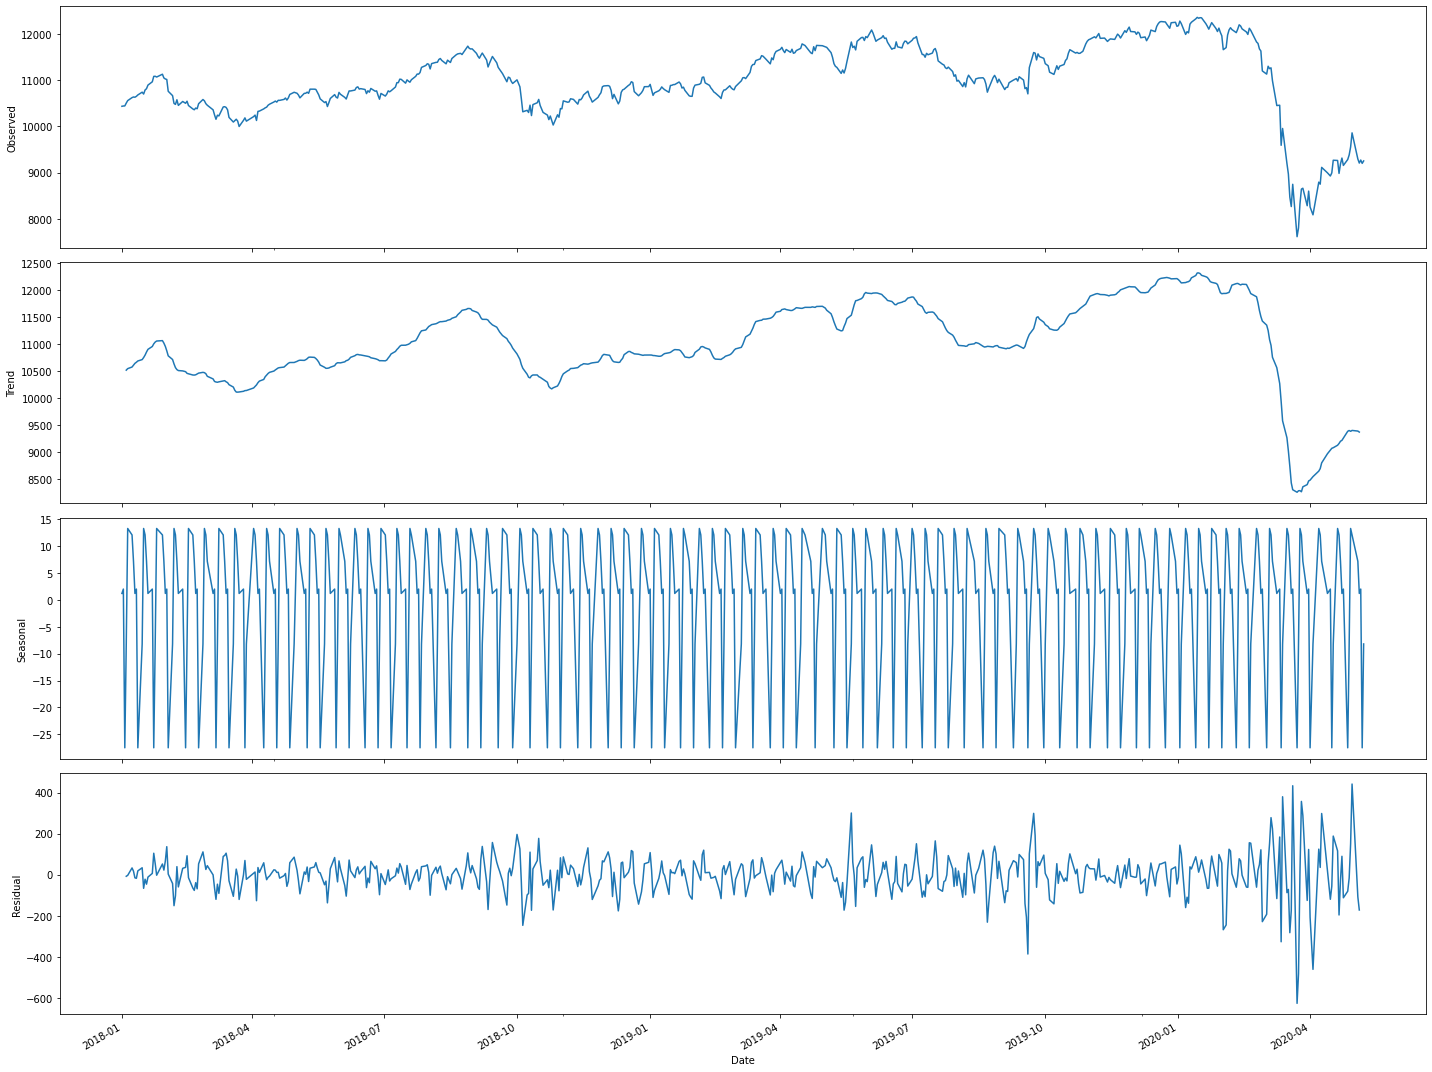

In [ ]:
decomposition_data = nifty_50_df['2018':'2020']
decomp_results = seasonal_decompose(decomposition_data['Close'], freq=7)
plt.rcParams["figure.figsize"] = (20,15)
figure = decomp_results.plot()

plt.show()

* There is an upward trend at first after there is downward trend.
* Also, we can see there is uniform seasonal change
* Non-uniform noise that represent outliers

# Autocorrelation and Partial Autocorrelation<a id='17'></a>

* **ACF (autocorrelation)** is the linear correlation of a signal with itself at two different points in time, ACF (autocorrelation function) is just such correlation as a function of the lag h between two points of time.

* **PACF (partial autocorrelation function)** is essentially the autocorrelation of a signal with itself at different points in time, with linear dependency with that signal at shorter lags removed, as a function of lag between points of time. Informally, the partial correlation between x(t) and x(t+h) is the autocorrelation between x(t) and x(t+h) without the contribution of x(t+1),x(t+2),....,x(t+h−1).

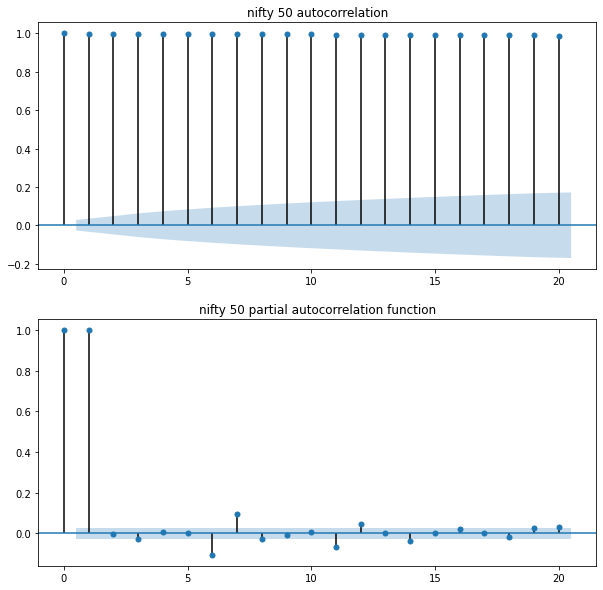

In [ ]:
plt.figure(figsize=(10,10))

# ACF of Nifty 50 close price
ax1 = plt.subplot(211)
plot_acf(nifty_50_df["Close"], lags="20",title="nifty 50 autocorrelation",ax=ax1)

# PACF of Nifty 50 close price
ax2 = plt.subplot(212)
plot_pacf(nifty_50_df["Close"], lags="20",title="nifty 50 partial autocorrelation function",ax=ax2)

plt.show()

* **In ACF** As all lags are either close to 1 or at least greater than the confidence interval, they are statistically significant.
* ** IN PCF** it is statistically signficant, partial autocorrelation after first 2 lags is very low.
* Here, only 0th, 1st, 6th, 7th, 11th and 12th lag are statistically significant.

## Using ACF and PACF to choose model order<a id='18'></a>
||AR(P)|MA(q)|ARMA(p,q)|
|--|--|--|--|
|ACF|Tails off|Cuts off after lag q|Tails off|
|PACF|Cuts off after lag P|Tails off|Tails off|

* 

## AIC(Akaike information criterion) And BIC (Bayesian information criterion)
 1.  **AIC**   
     * Lower AIC indicate batter model
     * AIC choose simple models with lower order
 2.  **BIC** 
     * Lower BIC indicate batter model
     * BIC favoures simple model then AIC
     * AIC is better at choosing predictive models 
     * BIC is better at choosing good explanatory model


In [ ]:
train_data = nifty_50_df["Close"]["2018":"4-15-2020"]
test_data =  nifty_50_df["Close"]["4-15-2020":]

In [ ]:
"""order_aic_bic =[] 
# Loop over AR order 
for p in range(6): 
    # Loop over MA order 
    for q in range(3): 
        # Fit model 
        for d in range(2):
            model = SARIMAX(train_data, order=(p,d,q)) 
            results = model.fit() 
            # Add order and scores to list 
            order_aic_bic.append((p,d, q, results.aic, results.bic))"""

'order_aic_bic =[] \n# Loop over AR order \nfor p in range(6): \n    # Loop over MA order \n    for q in range(3): \n        # Fit model \n        for d in range(2):\n            model = SARIMAX(train_data, order=(p,d,q)) \n            results = model.fit() \n            # Add order and scores to list \n            order_aic_bic.append((p,d, q, results.aic, results.bic))'

* we will choose lower aic value model

In [ ]:
order_df = pd.DataFrame(order_aic_bic, columns=['p','d','q', 'aic', 'bic'])
#short value by aic and get value of p d q
order_df.sort_values('aic')[:5]

NameError: ignored

* so we will choose P = 5 , d = 1 , q = 2

## SARIMAXA Model<a id='19'></a>

In [ ]:
model = SARIMAX(train_data, order=(5,1,2)) 
results = model.fit()

In [ ]:
mae = np.mean(np.abs(results.resid))
print(mae)

* How far our the predictions from the real values?

## Model diagnostics<a id='20'></a>

In [ ]:
plt.rcParams["figure.figsize"] = (15,10)
results.plot_diagnostics() 
plt.show()

* If the model fits well the residuals will be white Gaussian noise
* Histogram & KDE should be normally distributed
* Noraml Q-Q points should be almost on red line
* Correlogram of residuals should be zero for all legs

## Prediction on train data<a id='21'></a>

In [ ]:
prediction = results.get_prediction(start="7-2019")

In [ ]:
predictedmean = prediction.predicted_mean
p_bounds = prediction.conf_int()
p_lower_limit = p_bounds.iloc[:,0]
p_upper_limit = p_bounds.iloc[:,1]

## Forcasting on test data<a id='22'></a>

In [ ]:
forecast = results.get_forecast(steps=len(test_data))

In [ ]:
mean_forecast = forecast.predicted_mean
f_bounds = forecast.conf_int()
f_lower_limit = f_bounds.iloc[:,0]
f_upper_limit = f_bounds.iloc[:,1]

## Plot Prediction and Forcasting<a id='23'></a>

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(train_data.index, train_data, label='Original Closing Price(train)')
plt.plot(test_data.index, test_data, label='Original Closing Price(test)',color='k')

plt.plot(predictedmean.index, predictedmean, color='r', label='predicted')
plt.plot(test_data.index, mean_forecast, color='m', label='Forecast')

plt.fill_between(predictedmean.index,p_lower_limit,p_upper_limit, color='yellow')
plt.fill_between(test_data.index,f_lower_limit,f_upper_limit, color='y')

plt.xlabel('Date')
plt.ylabel('Nifty 50 Closing Price')
plt.legend()
plt.show()

* due to High changes in 2020 Nifty50 price we can see high difference between upper and lower bound of forecasting
* but also test data are inside the boundary

# LSTM

## Import Liberary<a id='24'></a>

In [ ]:
import keras
import keras.backend as K
K.clear_session()
from sklearn.preprocessing import MinMaxScaler

## Data Preprocessing<a id='25'></a>

In [ ]:
X = nifty_50_df.drop(["Close","Turnover","P/E","P/B","Div Yield"],axis=1)
y = nifty_50_df["Close"]

# Preprocessing
scaler = MinMaxScaler()
scaler_X = scaler.fit_transform(X)

X_df = pd.DataFrame(data=scaler_X, columns=["Open","High","Low","Volume"],index= X.index)
y_df = pd.DataFrame(data=y, columns=["Close"],index= y.index)

train_X_df = X_df["2000":"1-2-2020"]
test_X_df = X_df["1-2-2020":]

train_y_df = y_df["2000":"1-2-2020"]
test_y_df = y_df["1-2-2020":]

train_X = np.array(train_X_df)
test_X = np.array(test_X_df)

train_y = np.array(train_y_df)
test_y = np.array(test_y_df)

train_X = np.reshape(train_X,(train_X.shape[0],train_X.shape[1],1))
test_X = np.reshape(test_X,(test_X.shape[0],test_X.shape[1],1))

train_y = np.reshape(train_y,(train_y.shape[0],1))
test_y = np.reshape(test_y,(test_y.shape[0],1))

In [ ]:
print("Train X shape : ", train_X.shape)
print("Test X shape : ", test_X.shape)

print("Train y shape : ", train_y.shape)
print("Test y shape : ", test_y.shape)

## LSTM Model<a id='26'></a>

In [ ]:
lstm_model = keras.models.Sequential()
lstm_model.add(keras.layers.LSTM(128,
                                 input_shape=(train_X.shape[1],1),
                                 activation='relu',
                                 return_sequences=True
                                ))

lstm_model.add(keras.layers.LSTM(64,return_sequences=False,activation='relu'))

lstm_model.add(keras.layers.Dense(32,activation='relu'))
lstm_model.add(keras.layers.Dense(1))

lstm_model.compile(loss='mean_squared_error', optimizer='adam')

## Model Training<a id='27'></a>

In [ ]:
history = lstm_model.fit(train_X, train_y, batch_size=128,epochs=100, verbose=1, shuffle=False)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='MAE (training data)')
plt.title('MAE')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## Model Prediction<a id='28'></a>

In [ ]:
prediction = lstm_model.predict(test_X)

## RMS Error of model<a id='29'></a>

In [ ]:
np.sqrt(np.mean(((prediction - test_y) ** 2)))

## Plot Prediction<a id='30'></a>

In [ ]:
test_y_df["prediction"] = np.reshape(prediction,(prediction.shape[0]))

plt.figure(figsize=(12,8))

plt.plot(nifty_50_df["10-2018":].index,nifty_50_df["10-2018":]["Close"], label="Train Price")
plt.plot(test_y_df.index,test_y_df.prediction, label="predicted Price",color='r')
plt.plot(test_y_df.index,test_y_df.Close, label="test Price",color='m')

plt.xlabel('Date')
plt.ylabel('Nifty 50 Closing Price')
plt.legend()
plt.show()